In [7]:
%load_ext autoreload
%autoreload 2
import jax
from jax import random
from envs.rodent import RodentTracking

from brax.training.agents.ppo import networks as ppo_networks

import numpy as np
import mediapy as media
import os

import jax.numpy as jp
import mujoco
import warnings
from omegaconf import OmegaConf

warnings.filterwarnings("ignore", category=DeprecationWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load configs and reference clip 

In [9]:
from preprocessing.mjx_preprocess import process_clip
# We aren't using hydra like in training, so have to load and turn to dict
rodent_config = OmegaConf.load("./configs/env_config.yaml")["rodent"]
rodent_config = OmegaConf.to_container(rodent_config, resolve=True)
env_args = rodent_config["env_args"]
reference_clip = process_clip(
        rodent_config["stac_path"],
        start_step=rodent_config["clip_idx"] * env_args["clip_length"],
        clip_length=env_args["clip_length"],
    )


/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:154: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


In [ ]:
env = RodentTracking(reference_clip, **env_args)

In [16]:
key = random.PRNGKey(0)
jit_step = jax.jit(env.step)
jit_reset = jax.jit(env.reset)

In [17]:
next = jit_reset(key)
print("starting rollout")
mu = 0
sigma = 0.3
rollout = []
for _ in range(250):
    _, key = random.split(key)
    next = jit_step(next, mu + sigma * random.normal(key, shape=(env.sys.nu,)))
    rollout.append(next)

starting rollout


In [18]:
os.environ["MUJOCO_GL"] = "glfw"
rollout_data = [s.pipeline_state for s in rollout]

video = env.render(rollout_data, camera="side_alt", height=512, width=512)
media.show_video(video, fps=50)

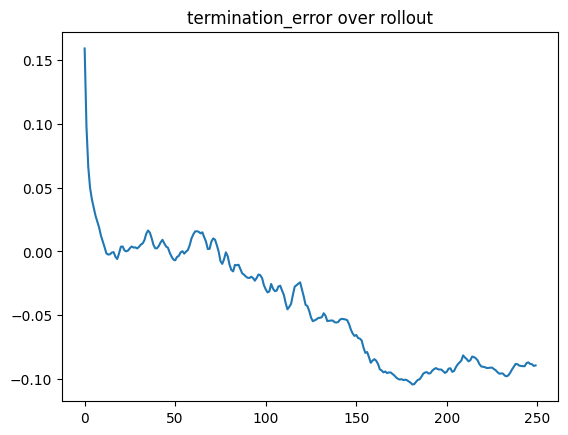

In [19]:
from matplotlib import pyplot as plt

# plot termination error over time:
errors = [s.metrics["termination_error"] for s in rollout]
plt.title("termination_error over rollout")
plt.plot(errors)